# Visualization of different altitude sensor measurements 
I need understand what each value is

## Plotting elevation values 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob

%matplotlib inline

In [2]:
cwd = os.getcwd()

#example parquet fdir for plotting
fdir = 'Tail_687_1_parquet'

#example parquet file
file = '687200104111158.parquet'
#file = '687200104181334.parquet' #bad lat long at end of file
pname = os.path.join(cwd,fdir,file)

df = pd.read_parquet(path=pname)


In [3]:
#output value to model with NN
Tlist = ['ALT']

#list of what I think are the dependent variables to create a model for T.
Xlist = ['time', 
         'RALT', 
         'ALTR', 'IVV', 'VSPS', 
         'VRTG', 'LATG', 'LONG', 'FPAC', 'BLAC', 'CTAC', 
         'PSA', 'PI', 'PT', 
         'TAS', 'CAS', 'GS', 'CASS', 'WS', 
         'PTCH', 'ROLL', 'DA', 
         'TAT', 'SAT', 
         'LATP', 'LONP']

##new list of what I think are the dependent variables to create a model for T.
#Xlist = ['time', 
#         'RALT', 
#         'PSA', 'PI', 'PT', 
#         'ALTR', 'IVV', 
#         'VRTG', 'LATG', 'FPAC', 'BLAC', 'CTAC', 
#         'TAS', 'CAS', 'GS', 'CASS', 'WS', 'PTCH', 'ROLL', 'DA', 'TAT', 
#         'SAT', 'LATP', 'LONP']

#may want to try this with Selected Alt (ALTS) in the Xlist

## Plotting current Lat/Long on a map

In [4]:
#latitude position
lat = df['LATP']
#longitudinal position
lon = df['LONP']

#bounding box
box = ((lon.min(), lon.max(),
        lat.min(), lat.max()))
box = ((-93.483, -83.983, 38.836, 45.236)) #actual bounding box of map image
print(lon.min(), lon.max(), lat.min(), lat.max())

lon

-93.42499249663791 -84.64589862839172 39.039747973315805 44.89631943502708


0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
          ..
125298   NaN
125299   NaN
125300   NaN
125301   NaN
125302   NaN
Name: LONP, Length: 125303, dtype: float64

Go to [openstreetmap.org](https://www.openstreetmap.org/export#map=5/51.500/-0.100) and enter the bounding box coordinates, then take a screen capture
of the exact square that is outlined.

'/ssd/MBSE/phd/research/work_folder/NASA'

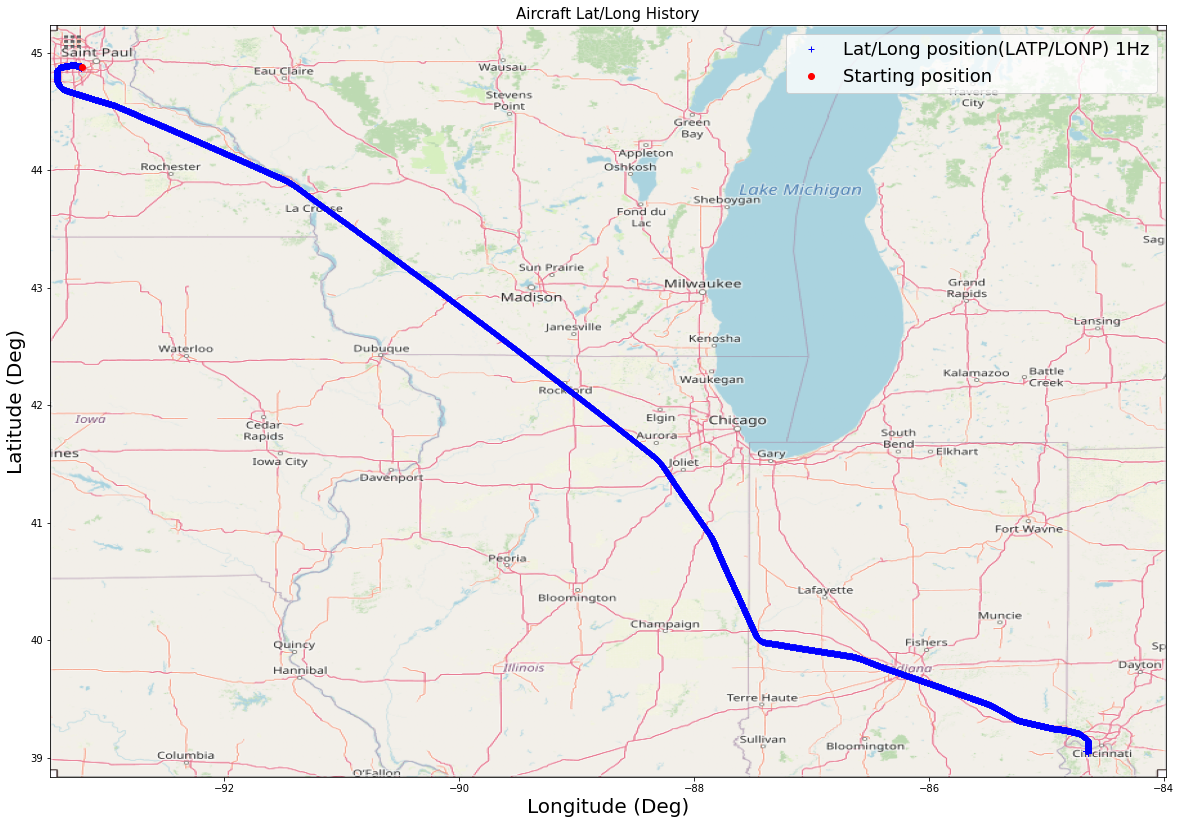

In [5]:
mapimg = plt.imread('map.png')

fig1 = plt.figure(figsize=(20, 15))


plt.plot(lon, lat,  'b+', label='Lat/Long position(LATP/LONP) 1Hz')
plt.plot(lon[1000], lat[1000],  'ro', label='Starting position')
ax = plt.gca()
ax.set_title('Aircraft Lat/Long History',fontsize=15)

ax.imshow(mapimg, zorder=0, extent=box, aspect='equal')

plt.xlabel('Longitude (Deg)',fontsize=20)
plt.ylabel('Latitude (Deg)',fontsize=20)
plt.legend(fontsize=18);
#minneapolis to cincinnati?
os.getcwd()

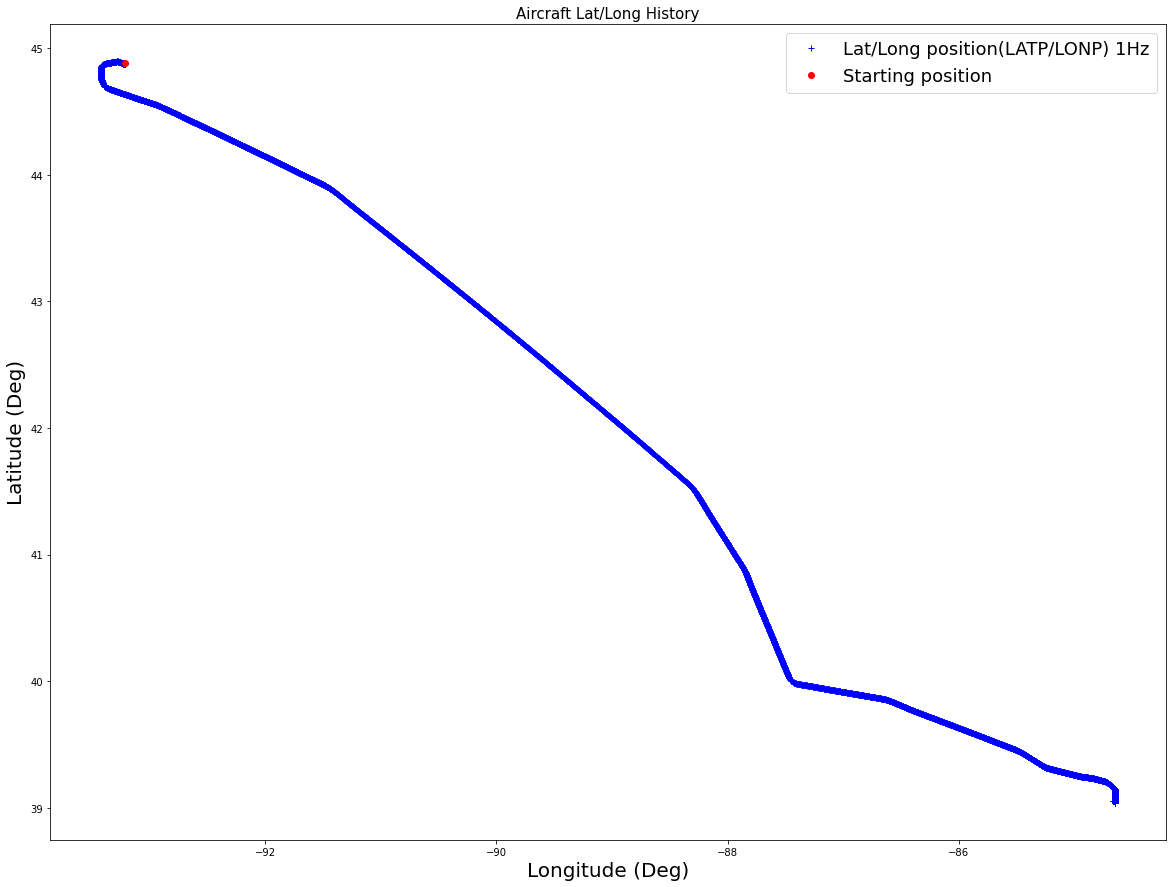

In [6]:
#mapimg = plt.imread('map.png')

fig1 = plt.figure(figsize=(20, 15))

plt.plot(lon, lat,  'b+', label='Lat/Long position(LATP/LONP) 1Hz')
plt.plot(lon[1000], lat[1000],  'ro', label='Starting position')
ax = plt.gca()
ax.set_title('Aircraft Lat/Long History',fontsize=15)

#ax.imshow(mapimg, zorder=0, extent=box, aspect='equal')

plt.xlabel('Longitude (Deg)',fontsize=20)
plt.ylabel('Latitude (Deg)',fontsize=20)
plt.legend(fontsize=18);
#minneapolis to cincinnati?

In [7]:
lon[78330:78340]

78330   NaN
78331   NaN
78332   NaN
78333   NaN
78334   NaN
78335   NaN
78336   NaN
78337   NaN
78338   NaN
78339   NaN
Name: LONP, dtype: float64

In [8]:
os.chdir('/ssd/MBSE/phd/research/work_folder/NASA')

# Looking at the elevation data downloaded from earthexplorer.usgs.gov

### Initial trial of gdallocationinfo

In [37]:
import os
fdir = '/ssd/MBSE/phd/research/work_folder/NASA/elevation_data/GMTED2010N30W120_075'
file = '30n120w_20101117_gmted_mea075.tif'
#info = gdal.Info(file, format='tif')
#print(info['wgs84Extent'])


cwd = os.getcwd()
os.chdir(fdir)

a_mean = !gdallocationinfo  -valonly -wgs84 30n120w_20101117_gmted_mea075.tif -93 44 
a_std = !gdallocationinfo  -valonly -wgs84 30n120w_20101117_gmted_std075.tif -93 44 


if a_mean[-1]:
    print('no error')
else:
    print('error: use a different file')

print(f'lat long location: [-93, 44]')
print(f'gdallocationinfo returns:')
print(f'{a_mean[-1]} meters (mean)')
print(f'{a_std[-1]} meters (std dev)')

#print(a)
os.chdir(cwd)
a_mean = float(a_mean[-1])
a_std = float(a_std[-1])

a_meanft = a_mean/0.3048
a_stdft = a_std/0.3048

print(f'\nI validated that these coordinates have an altitude of ~1,276ft on google: {a_meanft} ft \
with Standard Deviation {a_stdft} ft')

no error
lat long location: [-93, 44]
gdallocationinfo returns:
387 meters (mean)
1 meters (std dev)

I validated that these coordinates have an altitude of ~1,276ft on google: 1269.6850393700786 ft with Standard Deviation 3.280839895013123 ft


### read/write to input/output files for batch mode

In [10]:
import os
fdir = '/ssd/MBSE/phd/research/work_folder/NASA/elevation_data'

#this is a merged file containing most of the US.
#file = '30n120-090_gmted_mea150.tif'  #medium resolution
gmted_file = '30n120-090_gmted_mea075.tif'   #high resolution
gmted_stdfile = '30n120-090_gmted_std075.tif'   #high resolution
coord_file = '/tmp/lat-lon.csv'
elevation_file = '/tmp/elev.csv'


#flat = [44, 44, 44, 44, 44, 44]
#flong = [-93, -92, -91, -90, -89, -88]

lon = lon.interpolate(method='pad').bfill(axis=0)
lat = lat.interpolate(method='pad').bfill(axis=0)

cwd = os.getcwd()
os.chdir(fdir)

with open(coord_file, 'w') as f:
    for i in range(len(lat)):
        f.write(f'{lon[i]}  {lat[i]}')
        f.write('\n')


sysreturn = os.system(r'gdallocationinfo -valonly -wgs84 "%s" <%s >%s' % (gmted_file, coord_file, elevation_file));

#with open('output.csv','r') as f:
#    result = f.read()

eldf = pd.read_csv(elevation_file,header=None,names=['ELEVATION'])


##Delete the files
#try:
#    os.remove(coord_file)
#    os.remove(elevation_file)
#except OSError as e:  ## if failed, report it back to the user ##
#    print ("Error: %s - %s." % (e.filename, e.strerror))

os.chdir(cwd)


df['ELEVft'] = eldf[:]/0.3048

elev = df['ELEVft']

In [51]:
ihalf = np.round(lon.size/2).astype(int)
ihalf

print(f'Lat: {lat[ihalf]}')
print(f'Lon: {lon[ihalf]}')
print(f'Elevation: {elev[ihalf]} ft')

#Verified elevation at lat, lon via link below (point i tested was 4 feet off from mean)
#https://www.freemaptools.com/elevation-finder.htm

Lat: 43.1781594862083
Lon: -90.45747403643632
Elevation: 685.6955380577427 ft


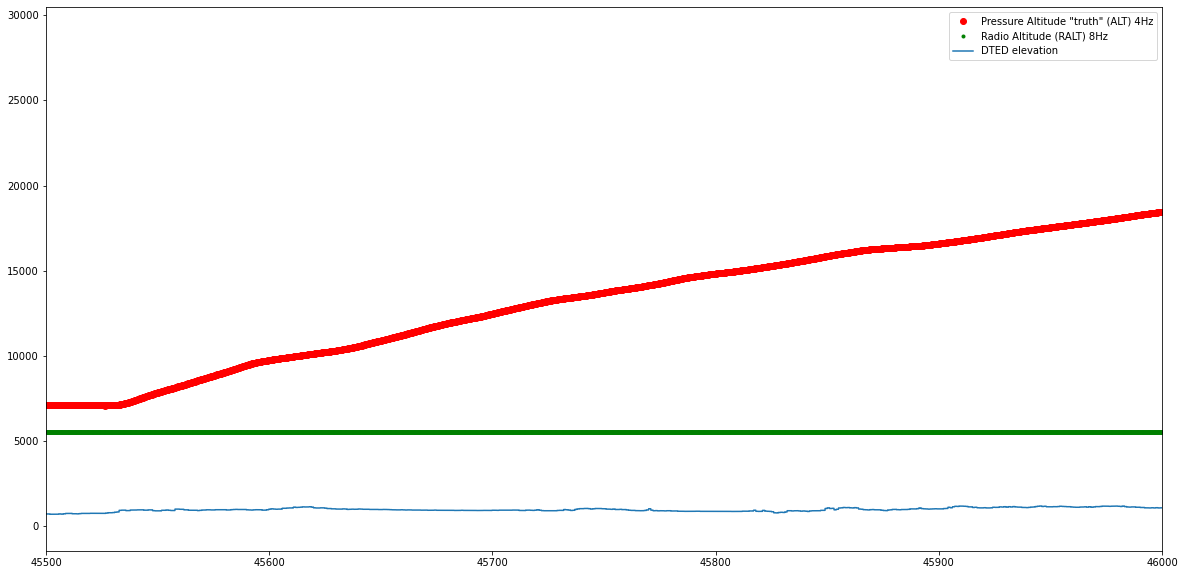

In [31]:

alt = df['ALT']
ralt = df['RALT']

xmin = 45500
xmax = 46000


time = df['time']
fig1 = plt.figure(figsize=(20, 10))

#plt.xlim(xmin, xmax)

#fig2 = plt.figure(figsize=(20, 10))
plt.plot(time, alt,  'ro', label='Pressure Altitude "truth" (ALT) 4Hz')
plt.plot(time, ralt, 'g.', label='Radio Altitude (RALT) 8Hz')
plt.plot(time,elev, label='DTED elevation')
plt.xlim(xmin, xmax)
plt.legend()